In [19]:
import pandas as pd
import json
import math
import hashlib
import numpy as np
import os
import matplotlib.pyplot as plt
from pandas import json_normalize
from glob import glob
from datetime import datetime, date
from math import radians, cos, sin, asin, sqrt
from scipy.stats import kde
from matplotlib.colors import ListedColormap
from tqdm import tqdm

In [20]:
GEOID_HEIGHT_M = 47  # geoid height for Cologne

# SERA.5005 Obstacle Clearance Criteria
limit_H_ft = 2000
limit_V_ft = 1000

# Distance to consider for the contour plot
prox_radius_ft = 2000 #2624 #1.3 * limit_H_ft

In [21]:
data_path = '../obstaclecheck/data_baseline/'
gdf_input_files = glob(data_path + 'gdf*.json')
gdf = pd.concat([pd.read_json(file, lines=False) for file in gdf_input_files])
gdf = gdf.reset_index(drop = True)
gdf['date'] = gdf.time.apply(lambda x: datetime.fromtimestamp(int(x)))

In [22]:
def bounding_box(lat, lon, half_dist_m):
    # Calculate latitudinal and longitudinal offsets in degrees
    lat_offset = (half_dist_m / 111120)  # 1 degree of latitude is approximately 111.12 km
    lon_offset = (half_dist_m / (111120 * abs(cos(radians(lat)))))  # 1 degree of longitude varies with latitude

    # Calculate the limits of the bounding box
    lat_min = lat - lat_offset
    lat_max = lat + lat_offset
    lon_min = lon - lon_offset
    lon_max = lon + lon_offset

    return lat_min, lat_max, lon_min, lon_max

In [23]:
def haversine(pt1, pt2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Returned units are in metres. Differs slightly from PostGIS geography
    distance, which uses a spheroid, rather than a sphere.
    """

    lat1, lon1 = pt1[0], pt1[1]
    lat2, lon2 = pt2[0], pt2[1]

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2.0) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371000  # Radius of earth in m
    return c * r

In [24]:
# Load obstacles

path_to_obstacles_json = './obstacles.json'

# Open obstacle database
with open(path_to_obstacles_json) as obstacles_database:
    obstacles_data = json.load(obstacles_database)
obs_df = pd.json_normalize(obstacles_data, record_path =['obstacles'])

obs_df = obs_df.sort_values(by=['height_m']) # sort obstacles by incresing height, to avoid that the min_hgt profil is wrong if a shorter obstacle comes after a taller one, in case the aircraft is within two obstacles clearance areas


In [25]:
results_df = pd.DataFrame()
results_df['Hso_ft'] = np.nan
results_df['Vso_ft'] = np.nan

0it [00:00, ?it/s]

processing Krohstr. 4 (Bayenthal)
8897


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
1it [00:02,  2.42s/it]

processing Heizwerk Kamine Südstadt
4493


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
2it [00:03,  1.80s/it]

processing AREO Turm
3949


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
3it [00:05,  1.56s/it]

processing Telekom-Hochhaus Sternengasse
17829


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
4it [00:09,  2.85s/it]/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy

processing DLF-Funkhaus
1218


/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
5it [00:10,  2.04s/it]

processing Herkules-Hochhaus
7250


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
6it [00:12,  2.08s/it]/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy

processing Justizzentrum
659


7it [00:13,  1.55s/it]

processing Koeln Triangle
17169


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
8it [00:17,  2.46s/it]

processing Ringturm
13298


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
9it [00:21,  2.87s/it]

processing TUV-Rheinland-Turm
3228


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
10it [00:22,  2.32s/it]

processing Pollonius
1299


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
11it [00:22,  1.80s/it]/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a cop

processing Uni-Center
568


12it [00:23,  1.38s/it]

processing Colonia Haus
2115


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
13it [00:24,  1.21s/it]

processing Koelner Dom
26124


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
14it [00:31,  2.96s/it]

processing Koelnturm (Mediapark)
12157


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
15it [00:34,  3.04s/it]

processing Colonius Fernsehturm
5354


/tmp/ipykernel_16488/3852465897.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
/tmp/ipykernel_16488/3852465897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)
16it [00:36,  2.25s/it]


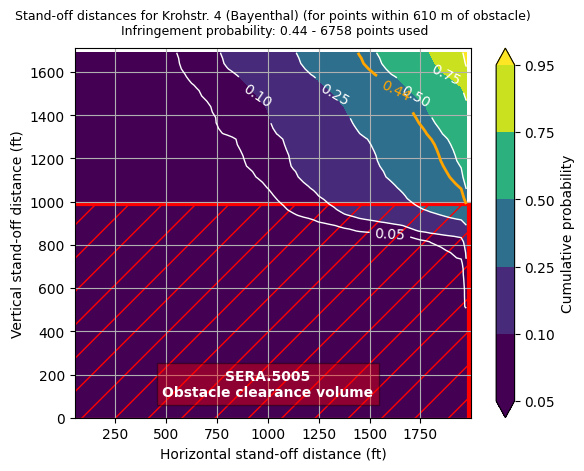

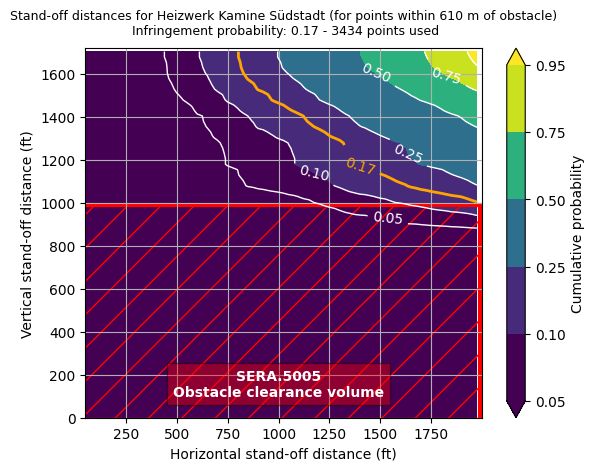

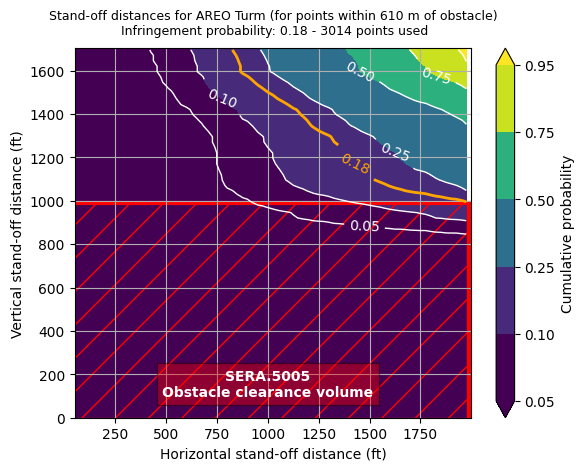

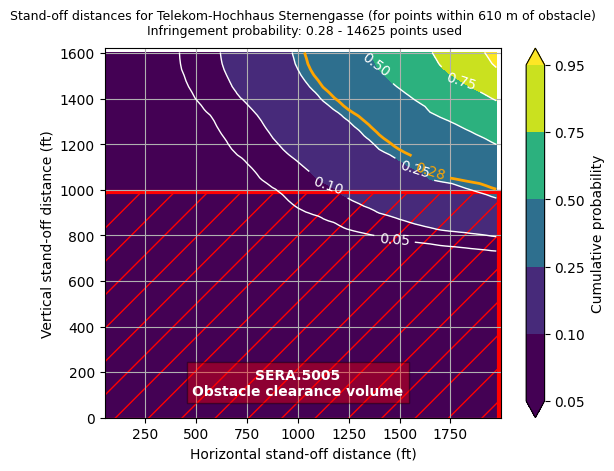

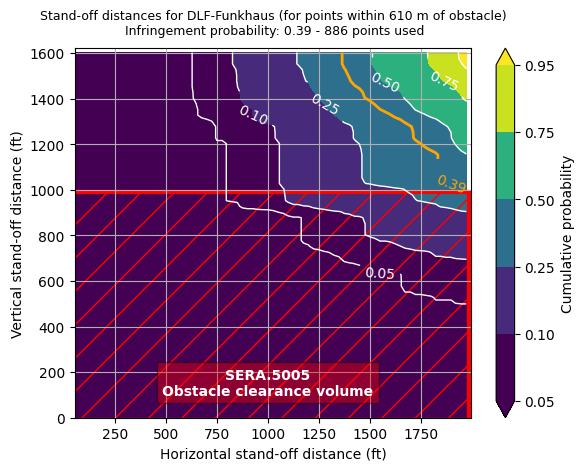

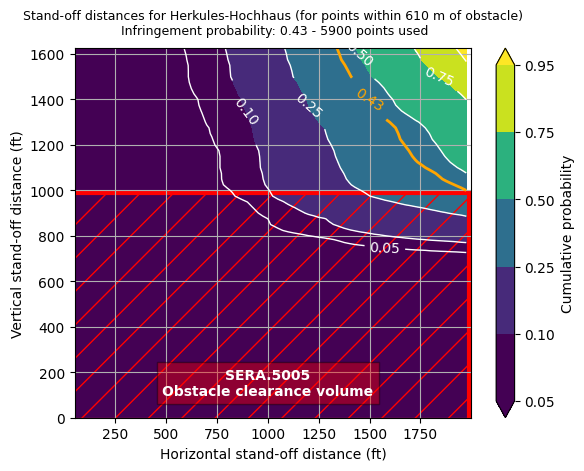

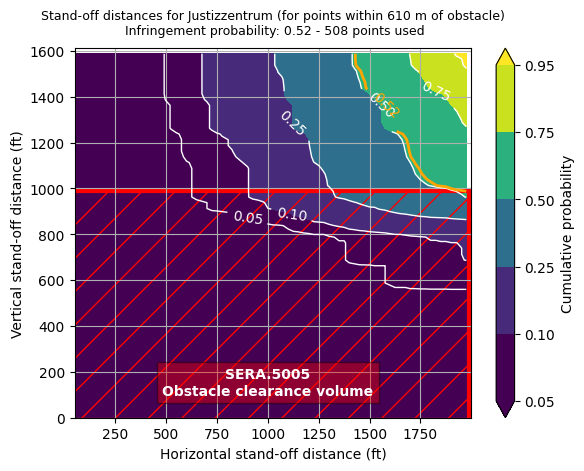

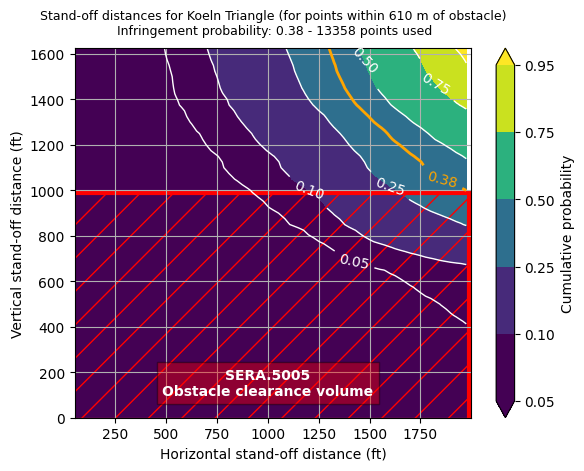

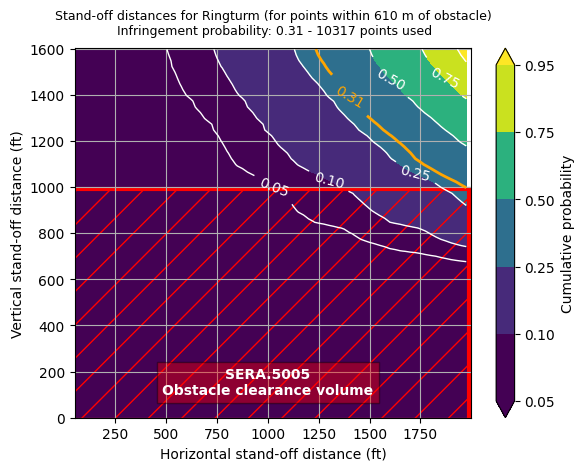

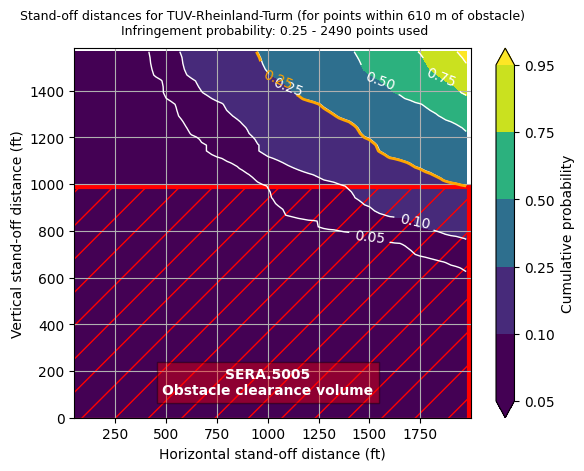

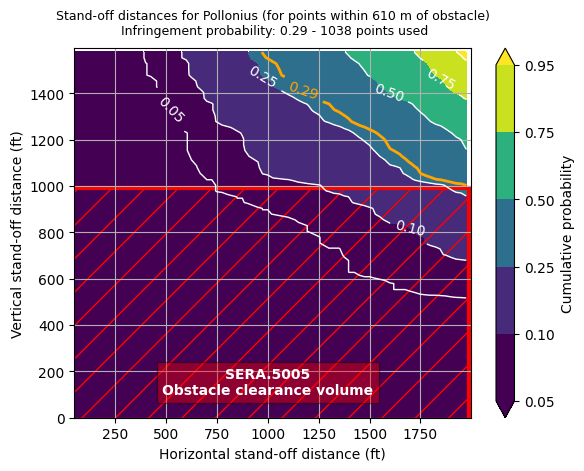

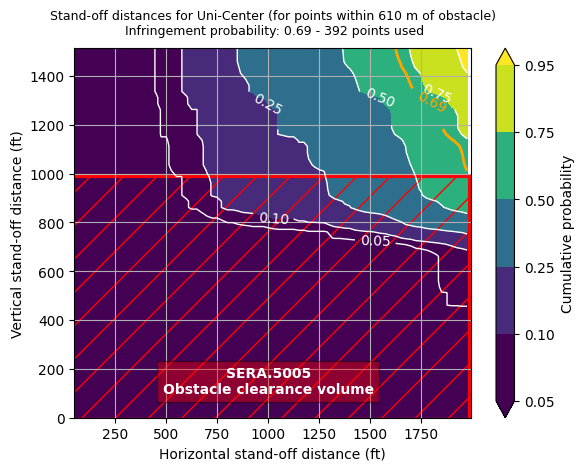

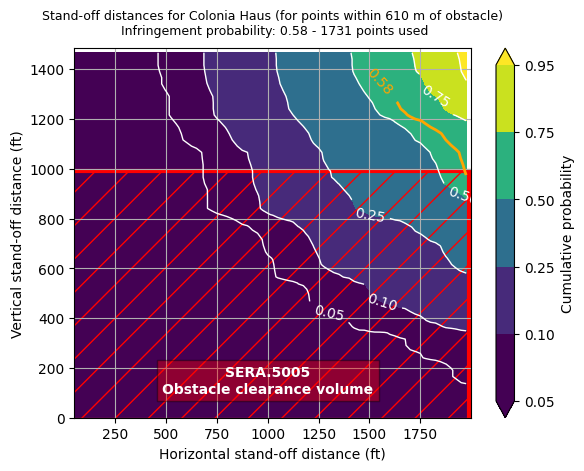

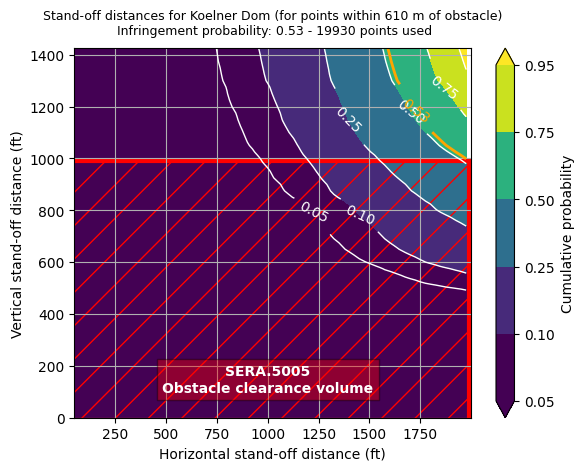

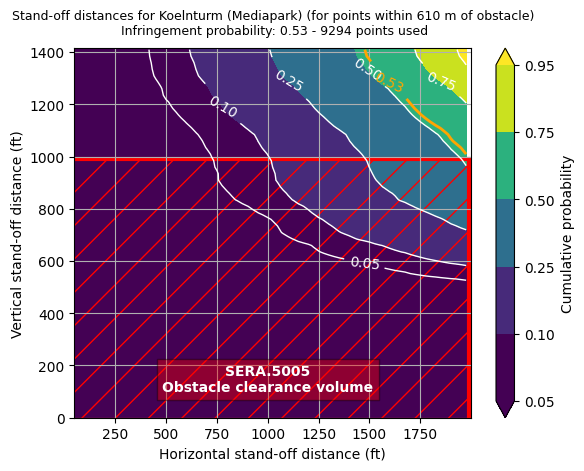

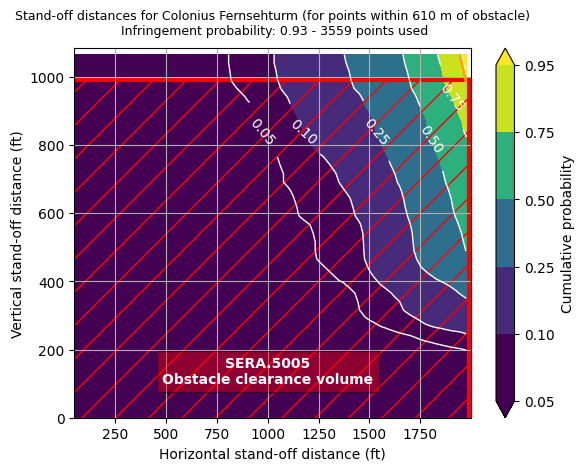

In [26]:
save_path = './results/radius_%sft/'%(prox_radius_ft)

for row_obs in tqdm(obs_df.itertuples()):

    obs_lat = row_obs.lat
    obs_lon = row_obs.lon
    obs_name = row_obs.name
    obs_hgt_m = row_obs.height_m
    obs_elev_m = row_obs.terrain_elevation_m

    print('processing %s'%(obs_name))

    min_alt_ft = (GEOID_HEIGHT_M + obs_elev_m + obs_hgt_m) / 0.3048

    lat_min, lat_max, lon_min, lon_max = bounding_box(obs_lat, obs_lon, prox_radius_ft * 0.3048)

    filtered_gdf = gdf.loc[(gdf.lat >= lat_min) & (gdf.lat <= lat_max) & (gdf.lon >= lon_min) & (gdf.lon <= lon_max)]

    print(len(filtered_gdf))

    filtered_gdf['Hso_ft'] = filtered_gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)
    filtered_gdf['Vso_ft'] = filtered_gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt_ft, axis = 1)

    filtered_gdf = filtered_gdf.loc[(filtered_gdf.Hso_ft <= prox_radius_ft)]


    temp_df = filtered_gdf[['Hso_ft', 'Vso_ft']]
    results_df = pd.concat((results_df, temp_df))

    # Assuming the DataFrame is named df with columns hmd_ft and vmd_ft
    maxHso_ft = filtered_gdf['Hso_ft'].max()
    maxVso_ft = filtered_gdf['Vso_ft'].max()

    # Calculate bin centers
    edgesX_ft = np.arange(0, maxHso_ft + 25, 25)
    edgesY_ft = np.arange(-maxVso_ft, maxVso_ft + 25, 25)
    centersX_ft = edgesX_ft[:-1] + np.diff(edgesX_ft) / 2
    centersY_ft = edgesY_ft[:-1] + np.diff(edgesY_ft) / 2

    # 2D Histogram
    hist, xedges, yedges = np.histogram2d(filtered_gdf['Hso_ft'], filtered_gdf['Vso_ft'], bins=(centersX_ft, centersY_ft), density=False)

    # Normalize the histogram to create CDF
    cdf = hist.cumsum(axis=0).cumsum(axis=1) / hist.sum()

    # Calculate bin centers using output of np.histogram2d
    Xcenters = xedges[:-1] + np.diff(xedges) / 2
    Ycenters = yedges[:-1] + np.diff(yedges) / 2

    # Plot CDF contour
    fig, ax = plt.subplots()
    c_levels = [0.05, 0.1, 0.25, 0.5, 0.75, 0.95]
    c_map = ListedColormap(plt.get_cmap('viridis')(np.linspace(0, 1, 20+len(c_levels))))
    CS = ax.contourf(Xcenters, Ycenters, cdf.T, levels=c_levels, cmap=c_map, extend='both')
    cbar = fig.colorbar(CS, ticks=c_levels, boundaries=np.linspace(0, 1, len(c_levels) + 1))
    cbar.ax.set_ylabel('Cumulative probability')

    # Add contour lines with labels
    CS_lines = ax.contour(Xcenters, Ycenters, cdf.T, levels=c_levels, colors='white', linewidths=1)
    ax.clabel(CS_lines, inline=True, fontsize=10, colors='white', fmt='%.2f')

    ## Add the contour line with the max probability corresponding to the SERA volume and set its color
    # Find the bins within the rectangle
    x_bins_in_rectangle = np.where((xedges[:-1] >= 0) & (xedges[:-1] <= limit_H_ft))[0]
    y_bins_in_rectangle = np.where((yedges[:-1] >= 0) & (yedges[:-1] <= limit_V_ft))[0]
    # Sum the counts in the bins within the rectangle and normalize by the total number of points
    rectangle_count = hist[np.ix_(x_bins_in_rectangle, y_bins_in_rectangle)].sum()
    probability_in_rectangle = rectangle_count / hist.sum()
    # Add the contour line
    CS_SERA_line = ax.contour(Xcenters, Ycenters, cdf.T, levels=[probability_in_rectangle], colors='orange', linewidths=2)
    ax.clabel(CS_SERA_line, inline=True, fontsize=10, colors='orange', fmt='%.2f')

    # Axes labels and grid
    ax.set_xlabel('Horizontal stand-off distance (ft)')
    ax.set_ylabel('Vertical stand-off distance (ft)')
    ax.grid(True)
    ax.set_xlim(50, maxHso_ft)
    ax.set_ylim(0, maxVso_ft)

    rectangle = plt.Rectangle((-10, -10), limit_H_ft, limit_V_ft, linewidth=3, edgecolor='red', facecolor='none', hatch='/', label = 'Stay well-clear volume (SERA.5005)')
    ax.add_patch(rectangle)
    plt.text(1000, 100,'SERA.5005\nObstacle clearance volume', color='white', horizontalalignment='center', weight='bold', bbox=dict(facecolor='red', alpha=0.4, edgecolor='black'))

    plt.title('Stand-off distances for %s (for points within %s m of obstacle)\n Infringement probability: %s - %s points used'%(obs_name, str(round(prox_radius_ft * 0.3048)), str(round(probability_in_rectangle, 2)),str(len(filtered_gdf))), fontsize=9, pad=10)

    fig_filename = save_path + 'Standoff_contour_%s.png'%(obs_name)

    plt.savefig(fig_filename)    

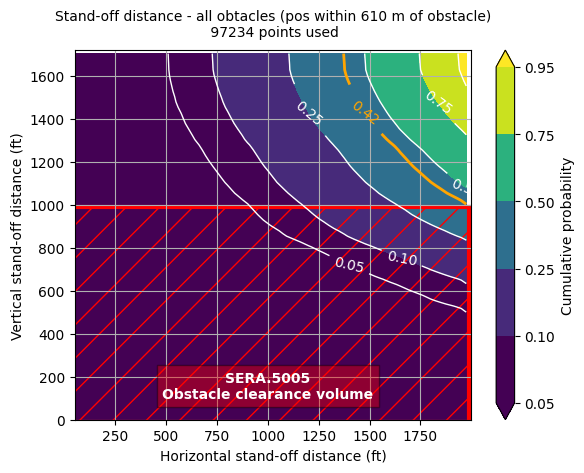

In [27]:
# Assuming the DataFrame is named df with columns hmd_ft and vmd_ft
maxHso_ft = results_df['Hso_ft'].max()
maxVso_ft = results_df['Vso_ft'].max()

# Calculate bin centers
edgesX_ft = np.arange(0, maxHso_ft + 25, 25)
edgesY_ft = np.arange(-maxVso_ft, maxVso_ft + 25, 25)
centersX_ft = edgesX_ft[:-1] + np.diff(edgesX_ft) / 2
centersY_ft = edgesY_ft[:-1] + np.diff(edgesY_ft) / 2

# 2D Histogram
hist, xedges, yedges = np.histogram2d(results_df['Hso_ft'], results_df['Vso_ft'], bins=(centersX_ft, centersY_ft), density=False)

# Normalize the histogram to create CDF
cdf = hist.cumsum(axis=0).cumsum(axis=1) / hist.sum()

# Calculate bin centers using output of np.histogram2d
Xcenters = xedges[:-1] + np.diff(xedges) / 2
Ycenters = yedges[:-1] + np.diff(yedges) / 2

# Plot CDF contour
fig, ax = plt.subplots()
c_levels = [0.05, 0.1, 0.25, 0.5, 0.75, 0.95]
c_map = ListedColormap(plt.get_cmap('viridis')(np.linspace(0, 1, 20+len(c_levels))))
CS = ax.contourf(Xcenters, Ycenters, cdf.T, levels=c_levels, cmap=c_map, extend='both')
cbar = fig.colorbar(CS, ticks=c_levels, boundaries=np.linspace(0, 1, len(c_levels) + 1))
cbar.ax.set_ylabel('Cumulative probability')

# Add contour lines with labels
CS_lines = ax.contour(Xcenters, Ycenters, cdf.T, levels=c_levels, colors='white', linewidths=1)
ax.clabel(CS_lines, inline=True, fontsize=10, colors='white', fmt='%.2f')

## Add the contour line with the max probability corresponding to the SERA volume and set its color
# Find the bins within the rectangle
x_bins_in_rectangle = np.where((xedges[:-1] >= 0) & (xedges[:-1] <= limit_H_ft))[0]
y_bins_in_rectangle = np.where((yedges[:-1] >= 0) & (yedges[:-1] <= limit_V_ft))[0]
# Sum the counts in the bins within the rectangle and normalize by the total number of points
rectangle_count = hist[np.ix_(x_bins_in_rectangle, y_bins_in_rectangle)].sum()
probability_in_rectangle = rectangle_count / hist.sum()
# Add the contour line
CS_SERA_line = ax.contour(Xcenters, Ycenters, cdf.T, levels=[probability_in_rectangle], colors='orange', linewidths=2)
ax.clabel(CS_SERA_line, inline=True, fontsize=10, colors='orange', fmt='%.2f')

# Axes labels and grid
ax.set_xlabel('Horizontal stand-off distance (ft)')
ax.set_ylabel('Vertical stand-off distance (ft)')
ax.grid(True)
ax.set_xlim(50, maxHso_ft)
ax.set_ylim(0, maxVso_ft)

#plt.scatter(results_df.Hso_ft, results_df.Vso_ft, alpha = 0.01, marker='x', color='red')

rectangle = plt.Rectangle((-10, -10), limit_H_ft, limit_V_ft, linewidth=3, edgecolor='red', facecolor='none', hatch='/', label = 'Stay well-clear volume (SERA.5005)')
ax.add_patch(rectangle)
plt.text(1000, 100,'SERA.5005\nObstacle clearance volume', color='white', horizontalalignment='center', weight='bold', bbox=dict(facecolor='red', alpha=0.4, edgecolor='black'))

plt.title('Stand-off distance - all obtacles (pos within %s m of obstacle)\n %s points used'%(str(round(prox_radius_ft * 0.3048)), str(len(results_df))), fontsize=10, pad=10)

fig_filename = save_path + 'Standoff_contour_All_obstacles.png'

plt.savefig(fig_filename)  